### Utilisation de Google Colab

Si vous utilisez Google Colab, suivez les instructions ci-dessous.

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. Installer ensuite deeplib avec la commande suivante:

In [1]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

  Cloning https://github.com/ulaval-damas/glo4030-labs.git to /tmp/pip-req-build-y5g6y93h
  Running command git clone --filter=blob:none --quiet https://github.com/ulaval-damas/glo4030-labs.git /tmp/pip-req-build-y5g6y93h
  Resolved https://github.com/ulaval-damas/glo4030-labs.git to commit c5c2d5abb7ddc59a63798ccb02b6109aa007c065
  Preparing metadata (setup.py) ... done



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


# Laboratoire 8: Transformers

Introduction aux transformers:
- Révolution dans le monde du NLP (Vaswani, 2017), maintenant les majeurs architectures de NLP sont toutes basées sur les transformers (BERT, GPT). Ex. Generative Pre-trained Transformer (GPT) et Bidirectional Encoder Representations from Transformers (BERT). ChatGPT basé sur GPT.
- Maintenant, les transformers sont aussi utilisés dans d'autres domaines du deep learning grâce à leur grande flexibilité et polyvalence. Vision par ordinateur: ViT, Swin, DETR, etc., Point Clouds: ..., Audio: ...
- Intéressant que le transformer de 2017 est encore utilisé! Seulement quelques petites modifications
- Une sorte d'architecture universelle qui peut traiter tout type de données
- Présentent une affinité pour le prétraining en raison de leur meilleur scaling avec la quantité de données et la taille du modèle (scaling vision transformer et Scaling laws for neural language models)

Transformers:
- Les transformers sont basés sur le principle d'attention
- Modèle ensemble -> ensemble de vecteurs (ensemble dans le sens mathématique)
- Réutilise des concepts intéressants: Connexion résiduelle (flot du gradient), LayerNorm, MLP
- Liens avec le message passing / algorithm


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pathlib

import numpy as np

import torch
import torch.random
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

import einops as ein

import deeplib.training as dtrain
import deeplib.datasets as ddatasets

Download tiny_shakespeare dataset

In [3]:
!curl -o ~/GLO-4030/datasets/tiny_shakespeare.txt https://raw.githubusercontent.com/karpathy/ng-video-lecture/master/input.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1089k  100 1089k    0     0  8706k      0 --:--:-- --:--:-- --:--:-- 8714k


## Partie 1: Scaled Dot-Product Attention
- Au coeur des transformers se trouve le principle d'attention
- Focus sur certaines parties de l'information, et moins sur d'autres, somme ponderée selon l'attention
- Dans le cas des transformers, on utilise le "Scaled Dot-Product Attention" de Attention Is All You Need" (Vaswani, 2017)
- Principle de requête sur une base de données, on fait une requête, et on reçois une réponse
- On fait une requête $q$ selon des clés $k$, et on reçoit un valeur $v$
- Mais ici $q, k, v$ sont des vecteurs, et $v$ est une somme pondérée de plusieurs valeurs de la "base de données"
- Plus formellement, on a $D = \{(k_1, v_1), \ldots (k_m, v_m)\}$, un ensemble de clés $k_i$ et leur valeur $v_i$ associée, requête $q$.
- L'affinité entre $q$ et les $k_i$ est calculée par une fonction $\alpha(q, k_i)$, la réponse est une somme pondérée des $v_i$ selon $\alpha(\cdot)$
$$Attention(q, D) = \sum_{i=1}^{m}{\alpha(q, k_i)}$$
- On normalise avec une softmax
$$\alpha(q, k_i) = \frac{\exp(\alpha(q, k_i))}{\sum_j\exp(\alpha(q, k_j))}$$
- Pour Vaswani, on utilise le scale dot-product attention
$$\alpha(q, k_i) = \frac{q^Tk_i}{\sqrt{d}} = \frac{q \cdot k_i }{\sqrt{d}}$$
- $d$ est la dimension des vecteurs
- Au final, avec la softmax
$$\alpha(q, k_i) = \frac{\exp\left(q \cdot k_i / \sqrt{d}\right)}{\sum_j\exp\left(q \cdot k_i / \sqrt{d}\right)}$$

Dans la cellule suivante, remplisser la fonction suivante pour appliquer l'attention sur les tenseurs $q$, $k$ et $v$.

In [4]:
def simple_attention(q, k, v):
    """
    Attention simple
    q est un tenseur de dimension (1, d)
    k est un tenseur de dimension (n, d)
    v est un tenseur de dimension (n, d)
    d est la dimension des vecteurs, n le nombre de clés et de valeurs
    La sortie devrait être de dimension (1, d)
    """
    # TODO
    d = q.size(-1)
    alpha = F.softmax(q @ k.T / np.sqrt(d), dim=1)
    return alpha @ v
    
q = F.normalize(torch.tensor([[3.0, 3.0]]), dim=1)
k = F.normalize(torch.tensor([[2.0, 1.5], [-4, 3], [0, 3], [-1, -4]]), dim=1)
v = F.normalize(torch.tensor([[-1.0, 2], [3, 4], [2, -1], [0, 2]]), dim=1)

expected = torch.tensor([[0.2185, 0.4563]])
output = simple_attention(q, k, v)

print(f'simple_attention(q, k, v) =\t{output}')
print(f'valeur attendue =\t\t{expected}')

simple_attention(q, k, v) =	tensor([[0.2185, 0.4563]])
valeur attendue =		tensor([[0.2185, 0.4563]])


### Visualisation de l'attention
- Le produit scalaire a une interprétation utile, $q\cdot k_i = \|q\|\|k_i\|\cos(\theta)$, il s'agit donc d'une mesure de comment les vecteurs sont alligés


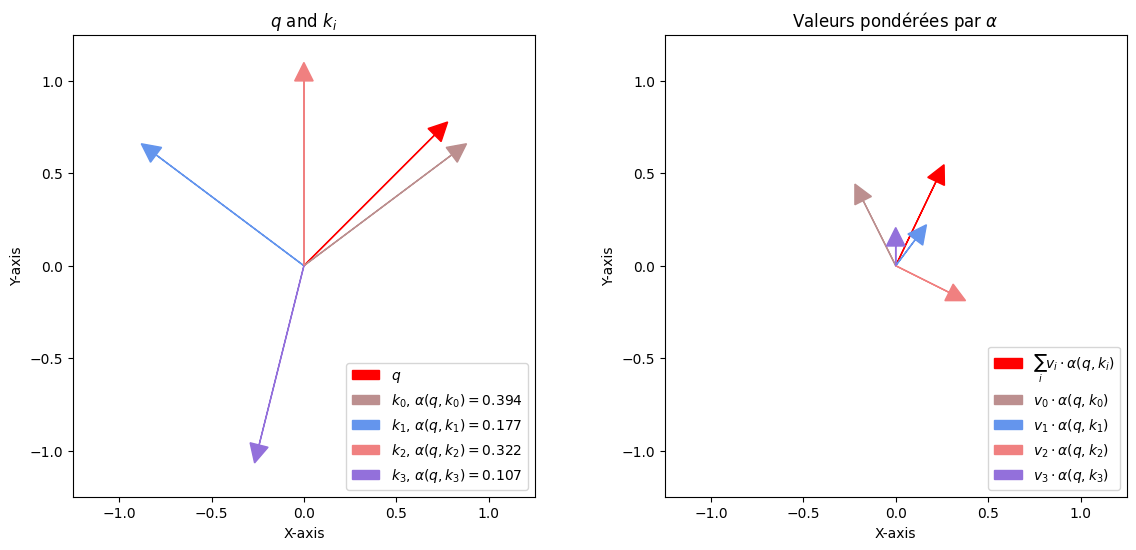

In [5]:
def show_attention(q, k, v):
    # TODO
    d = q.size(-1)
    alpha = F.softmax(q @ k.T / np.sqrt(d), dim=1)
    
    figs, axes = plt.subplots(ncols=2, figsize=(14, 6))
    ax = axes[0]
    ax.arrow(0, 0, q[0][0], q[0][1], head_width=0.1, head_length=0.1, fc='red', ec='red', label='$q$')

    colors = ['rosybrown', 'cornflowerblue', 'lightcoral', 'mediumpurple']
    for i, k_i in enumerate(k):
        ax.arrow(0, 0, k_i[0], k_i[1], head_width=0.1, head_length=0.1, label=f'$k_{i}$, $\\alpha(q, k_{i}) = {alpha[0][i]:.3f}$', fc=colors[i], ec=colors[i])

    ax.set_xlim(-1.25, 1.25)
    ax.set_ylim(-1.25, 1.25)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('$q$ and $k_i$')
    ax.legend(loc='lower right')
    ax.set_aspect('equal', adjustable='box')
    
    ax = axes[1]
    ax.arrow(0, 0, output[0][0], output[0][1], head_width=0.1, head_length=0.1, fc='red', ec='red', label='$\sum_i v_{i} \cdot \\alpha(q, k_{i})$')

    for i, v_i in enumerate(v):
        v_i = v_i * alpha[0, i]
        ax.arrow(0, 0, v_i[0], v_i[1], head_width=0.1, head_length=0.1, label=f'$v_{i} \cdot \\alpha(q, k_{i})$', fc=colors[i], ec=colors[i])

    ax.set_xlim(-1.25, 1.25)
    ax.set_ylim(-1.25, 1.25)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(r'Valeurs pondérées par $\alpha$')
    ax.legend(loc='lower right')
    ax.set_aspect('equal', adjustable='box')

    plt.show()
    
show_attention(q, k, v)

#### Questions
- Quel clé est la plus alignée avec $q$?
- Que ce passe-t'il avec les valeurs de $\alpha(\cdot)$ lorsque vous changer les $k_i$?
- Quel est l'impact sur la valeur retournée par l'attention?

### Le "Scaled" dans Scaled Dot-Product Attention
- Le facteur de $\frac{1}{\sqrt{d}}$ peut sembler inutile, pourtant il est central au bon fonctionnement de l'attention
- Si on fait l'hypothèse que $q_i$ et $k_i$ suivent une distribution normale $\mathcal{N}(0, 1)$, le produit entre $q$ et $k$ aura une variance de $d$.
- Il faut donc diviser par $\sqrt{d}$ afin d'obtenir une variance de $1$.

In [6]:
torch.manual_seed(1337)
num_tokens = 32
dimension = 256

q = torch.randn(num_tokens, dimension)
k = torch.randn(num_tokens, dimension)

attention = q @ k.T
scaled_attention = attention * dimension ** -0.5

print(f'Variance sans scaling: {attention.var()}')
print(f'Variance avec scaling: {scaled_attention.var()}')

Variance sans scaling: 259.6633605957031
Variance avec scaling: 1.0143100023269653


Sans scaling
- Sans scaling, la softmax va converger vers un vecteur one-hot.
- Ceci à pour effet de ne seulement aggréger de l'informatique que d'une seule valeur, limitant ainsi les performances du transformer.
- Le scaling permet une meilleure initialisation, et facilite l'optimisation du transformer

In [7]:
low_variance = torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)
high_variance = torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]) * np.sqrt(256), dim=-1)

print(f'Softmax avec faible variance:\n\t{[round(x.item(), 5) for x in low_variance]}')
print(f'Softmax avec haute variance:\n\t{[round(x.item(), 5) for x in high_variance]}')

Softmax avec faible variance:
	[0.1925, 0.14261, 0.23512, 0.14261, 0.28717]
Softmax avec haute variance:
	[0.00159, 1e-05, 0.0391, 1e-05, 0.95928]


### Plusieurs queries
- Implémenter pour de l'attention avec plusieurs requêtes $q_i$
- On veut comparer chaque requête $q_i$ avec chaque clé $k_i$, on va le faire grâce à la multiplication de tenseurs

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d}}\right)V$$

$$Q=\begin{pmatrix}
q_1\\
q_2\\
\vdots\\
q_n
\end{pmatrix}, K=\begin{pmatrix}
k_1\\
k_2\\
\vdots\\
k_n
\end{pmatrix}, V=\begin{pmatrix}
v_1\\
v_2\\
\vdots\\
v_n
\end{pmatrix}$$

$$QK^T = \begin{pmatrix}
q_1\\
q_2\\
\vdots\\
q_n
\end{pmatrix} K=\begin{pmatrix}
k_1 & k_2 & \dots & k_n
\end{pmatrix} = \begin{pmatrix}
q_1k_1 & q_1k_2 & \dots  & q_1k_n \\
q_2k_1 & q_2k_2 & \dots  & q_2k_n \\
\vdots & \vdots & \ddots & \vdots \\
q_nk_1 & q_nk_2 & \dots  & q_nk_n \\
\end{pmatrix}$$

On appelle $QK^T$ la matrice d'attention.

Si on ignore la softmax et le scale, on a 
$$QK^TV = \begin{pmatrix}
q_1k_1 & q_1k_2 & \dots  & q_1k_n \\
q_2k_1 & q_2k_2 & \dots  & q_2k_n \\
\vdots & \vdots & \ddots & \vdots \\
q_nk_1 & q_nk_2 & \dots  & q_nk_n \\
\end{pmatrix}\begin{pmatrix}
v_1\\
v_2\\
\vdots\\
v_n
\end{pmatrix}=\begin{pmatrix}
q_1k_1v_1 + q_1k_2v_2 + \dots  + q_1k_nv_n \\
q_2k_1v_1 + q_2k_2v_2 + \dots  + q_2k_nv_n \\
\vdots \\
q_nk_1v_1 + q_nk_2v_2 + \dots  + q_nk_nv_n \\
\end{pmatrix}$$

In [8]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Attention sur batch
    q est un tenseur de dimension (b, n, d)
    k est un tenseur de dimension (b, n, d)
    v est un tenseur de dimension (b, n, d)
    b est la taille de la mini-batch, d est la dimension des vecteurs, n le nombre de clés et de valeurs
    La sortie devrait être de dimension (b, n, d)
    """
    # TODO
    attention = q.bmm(k.transpose(-2, -1))  # or query @ key.transpose(1, 2)
    if mask is not None:
        attention[:, mask.logical_not()] = -torch.inf
    
    scale = q.size(-1) ** 0.5
    softmax = F.softmax(attention / scale, dim=-1)
    return softmax.bmm(v)

q = F.normalize(torch.tensor([[3.0, 3.0], [-1, 3.2], [0.2, -0.4], [0, -1]]), dim=1).unsqueeze(0)
k = F.normalize(torch.tensor([[2.0, 1.5], [-4, 3], [0, 3], [-1, -4]]), dim=1).unsqueeze(0)
v = F.normalize(torch.tensor([[-1.0, 2], [3, 4], [2, -3], [0, 2]]), dim=1).unsqueeze(0)

expected = torch.tensor([[[0.1089, 0.3322], [0.2860, 0.2639], [0.0600, 0.6791], [0.0986, 0.7087]]])
output = scaled_dot_product_attention(q, k, v)

print(f'scaled_dot_product_attention(q, k, v) =\n{output}')
print(f'valeur attendue =\n{expected}')

scaled_dot_product_attention(q, k, v) =
tensor([[[0.1089, 0.3322],
         [0.2860, 0.2639],
         [0.0600, 0.6791],
         [0.0986, 0.7087]]])
valeur attendue =
tensor([[[0.1089, 0.3322],
         [0.2860, 0.2639],
         [0.0600, 0.6791],
         [0.0986, 0.7087]]])


#### Questions
- Quelle est la taille du tenseur lorsque l'on multiple $q$ et $v$? Est-ce problématique pour le temps de calculs et la mémoire utilisée si $n$ (le nombre de queries, keys et valeurs) augmente?
- Que se passe-t'il si on change l'ordre des queries?
- Que se passe-t'il si on change l'ordre des clés et des valeurs?
- Est-ce l'invariance à l'ordre des entrées est problématique? Quant est-t'il si l'ordre des valeurs est importante? comme l'ordre des mots dans une phrase

#### Masques
Implémentez l'opération de masking dans la fonction `scaled_dot_product_attention`. Il s'agit de remplacer les éléments de la matrice d'attention par $-\infty$ où le mask est False.

In [9]:
q = F.normalize(torch.tensor([[3.0, 3.0], [-1, 3.2], [0.2, -0.4], [0, -1]]), dim=1).unsqueeze(0)
k = F.normalize(torch.tensor([[2.0, 1.5], [-4, 3], [0, 3], [-1, -4]]), dim=1).unsqueeze(0)
v = F.normalize(torch.tensor([[-1.0, 2], [3, 4], [2, -3], [0, 2]]), dim=1).unsqueeze(0)
mask = torch.tensor([[1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 1, 0], [1, 1, 1, 1]], dtype=torch.bool)

expected = torch.tensor([[[-0.4472,  0.8944], [ 0.1639,  0.8393], [ 0.1129,  0.3967], [ 0.0986,  0.7087]]])
output = scaled_dot_product_attention(q, k, v, mask)

print(f'scaled_dot_product_attention(q, k, v) =\n{output}')
print(f'valeur attendue =\n{expected}')

scaled_dot_product_attention(q, k, v) =
tensor([[[-0.4472,  0.8944],
         [ 0.1639,  0.8393],
         [ 0.1129,  0.3967],
         [ 0.0986,  0.7087]]])
valeur attendue =
tensor([[[-0.4472,  0.8944],
         [ 0.1639,  0.8393],
         [ 0.1129,  0.3967],
         [ 0.0986,  0.7087]]])


#### Visualisation de l'attention
- Voir la matrice d'attention

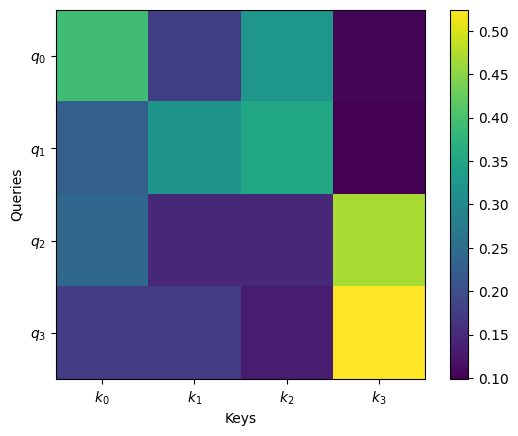

In [10]:
q = F.normalize(torch.tensor([[3.0, 3.0], [-1, 3.2], [0.2, -0.4], [0, -1]]), dim=1).unsqueeze(0)
k = F.normalize(torch.tensor([[2.0, 1.5], [-4, 3], [0, 3], [-1, -4]]), dim=1).unsqueeze(0)

# TODO
attention = q.bmm(k.transpose(-2, -1)) / q.size(-1) ** 0.5
softmax = F.softmax(attention, dim=-1)

qs = [f'$q_{i}$' for i in range(q.size(1))]
ks = [f'$k_{i}$' for i in range(q.size(1))]

plt.imshow((softmax[0]))

plt.xticks(range(q.size(1)), ks)
plt.yticks(range(q.size(1)), qs)

plt.xlabel('Keys')
plt.ylabel('Queries')

plt.colorbar()
plt.show()

#### Questions
- Que se passe-t'il lors de l'ajout d'un mask?
- Permutez l'ordre des $q_i$, que ce passe-t'il avec la matrice d'attention?
- Permutez l'ordre des $k_i$, que remarquez-vous?

### Encodage de position
Comme les transformers sont invariants à la permutation des $q_i$ et des pairs $(k_i, v_i)$, on doit encoder la position.

Implémenter l'encodage de position dans la cellule suivante. Il vous faudra générer un tenseur (1, n, dimension), où n est le nombre de clés, selon les formules suivantes:

$$\text{PE}_{pos, 2i} = \sin(\text{pos} / 10000^{i/d})$$

$$\text{PE}_{pos, 2i + 1} = \cos(\text{pos} / 10000^{i/d})$$


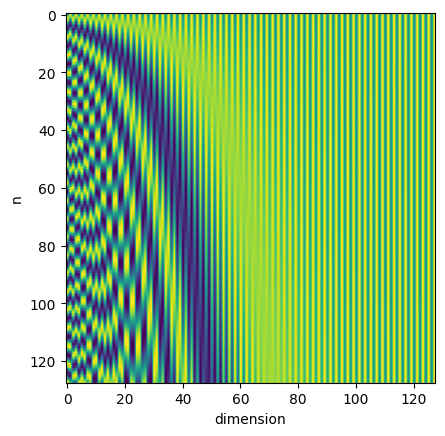

In [11]:
def position_encoding(n_keys: int, dimension: int, device: torch.device = torch.device("cpu")):
    # TODO
    pos = torch.arange(n_keys, dtype=torch.float, device=device).reshape(1, -1, 1)
    dim = torch.arange(dimension, dtype=torch.float, device=device).reshape(1, 1, -1)
#     phase = pos / (10000 ** (2 * dim / dimension))
    phase = pos / (10000 ** (dim / dimension))

    return torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))

pe = position_encoding(128, 128)
plt.imshow(pe.squeeze())
plt.xlabel('dimension')
plt.ylabel('n')
plt.show()

In [12]:
q = F.normalize(torch.tensor([[3.0, 3.0], [-1, 3.2], [0.2, -0.4], [0, -1]]), dim=1).unsqueeze(0)
k = F.normalize(torch.tensor([[2.0, 1.5], [-4, 3], [0, 3], [-1, -4]]), dim=1).unsqueeze(0)
v = F.normalize(torch.tensor([[-1.0, 2], [3, 4], [2, -3], [0, 2]]), dim=1).unsqueeze(0)

_, n, d = q.shape

# TODO
q += position_encoding(n, d)
k += position_encoding(n, d)

scaled_dot_product_attention(q, k, v)

tensor([[[0.2614, 0.0326],
         [0.2765, 0.0179],
         [0.1590, 0.2344],
         [0.1739, 0.4437]]])

#### Questions
- Maintenant, que se passe-t'il lorsque l'on permute les $q_i$? et les $(k_i, v_i)$?

## Partie 2: Multi-Head Attention
- Temps d'en faire un Module PyTorch

### AttentionHead
- Faites un module PyTorch qui utilise 3 couches linéaires pour respectivement projetter q, k et v, avant d'appliquer de l'attention
- Linear sans biais
- Dropout sur la matrice d'attention

In [13]:
class AttentionHead(nn.Module):
    def __init__(self, dim_embed: int, head_size: int, dropout: float):
        super().__init__()
        # TODO
        self.q_proj = nn.Linear(dim_embed, head_size, bias=False)
        self.k_proj = nn.Linear(dim_embed, head_size, bias=False)
        self.v_proj = nn.Linear(dim_embed, head_size, bias=False)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        # TODO
        B, T, C = q.shape
        q, k, v = self.q_proj(q), self.k_proj(k), self.v_proj(v)
        
        attention = q.bmm(k.transpose(-2, -1))  # or query @ key.transpose(1, 2)
        if mask is not None:
            attention[:, mask[:T, :T].logical_not()] = -torch.inf
    
        scale = q.size(-1) ** 0.5
        softmax = F.softmax(attention / scale, dim=-1)
        
        softmax = self.dropout(softmax)
        
        return softmax.bmm(v)

    
head = AttentionHead(16, 32, 0.1)
x = torch.randn((1, 6, 16))
output = head(x, x, x)

print(f'Shape \t\t= {tuple(output.shape)}')
print(f'Expected shape \t= {(1, 6, 32)}')

Shape 		= (1, 6, 32)
Expected shape 	= (1, 6, 32)


### Multi-Head Attention
- Plusieurs têtes d'attention
- Plusieurs cannaux de communication séparés pour query les keys

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, dim_embed: int, head_size: int, dropout: float):
        super().__init__()
        # TODO
        self.heads = nn.ModuleList([AttentionHead(dim_embed, head_size, dropout) for _ in range(num_heads)])
        self.fc = nn.Linear(num_heads * head_size, dim_embed)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        # TODO
        out = torch.cat([h(q, k, v, mask) for h in self.heads], dim=-1)
        return self.dropout(self.fc(out))

    
m_head = MultiHeadAttention(3, 32, 256, 0.1)
x = torch.randn((1, 6, 32))
output = m_head(x, x, x)

print(f'Shape \t\t= {tuple(output.shape)}')
print(f'Expected shape \t= {(1, 6, 32)}')

Shape 		= (1, 6, 32)
Expected shape 	= (1, 6, 32)


## Partie 3: TransformerEncoderLayer
- Multi-head self-attention
- Add and norm
- FF par token (attention = communication, FF est le token qui "pense")
- Connexion residuelle / skip (flot du gradient car l'addition distribue le grad egalement à chaque branche, aide à être deep, apprendre un delta)
- Prenorm vs postnorm

### FeedForward
- Linear dim_model -> 4 * dim_model
- ReLU
- Linear 4 * dim_model -> dim_model
- Dropout

In [15]:
class FeedForward(nn.Module):
    def __init__(self, dim_model: int, dropout: float):
        super().__init__()
        # TODO
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, 4 * dim_model),
            nn.ReLU(),
            nn.Linear(4 * dim_model, dim_model),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.ffn(x)


### TransformerEncoderLayer
- LayerNorm
- MultiHeadAttention
- Connexion résiduelle
- LayerNorm
- FeedForward
- Connexion résiduelle

In [16]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, dim_model: int, num_head: int, dropout: float):
        super().__init__()
        # TODO
        head_size = dim_model // num_head
        self.attention = MultiHeadAttention(num_head, dim_model, head_size, dropout)
        self.ffn = FeedForward(dim_model, dropout)
        self.norm1_q = nn.LayerNorm(dim_model)
        self.norm1_k = nn.LayerNorm(dim_model)
        self.norm1_v = nn.LayerNorm(dim_model)
        self.norm2 = nn.LayerNorm(dim_model)
        
    def forward(self, q, k, v, mask=None):
        q = q + self.attention(self.norm1_q(q), self.norm1_k(k), self.norm1_v(v), mask)
        q = q + self.ffn(self.norm2(q))
        return q
    
transf = TransformerEncoderLayer(64, 2, 0.1)
x = torch.randn((1, 6, 64))
output = transf(x, x, x)

print(f'Shape \t\t= {tuple(output.shape)}')
print(f'Expected shape \t= {(1, 6, 64)}')

Shape 		= (1, 6, 64)
Expected shape 	= (1, 6, 64)


### BatchNorm vs LayerNorm
- BatchNorm et LayerNorm centrent les features en entrée selon des statistiques calculées sur les valeurs
- BatchNorm normalise selon des statistiques sur la batch (batch-wise)
- LayerNorm normalise dans l'autre axe, selon les features
- LayerNorm ne demande pas de moyenne exponentielle, pas de difference entre train et test

In [17]:
torch.manual_seed(42)
batch_size = 32
dimension = 100

net = nn.Sequential(nn.Linear(100, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 100))

x = torch.randn(batch_size, dimension)
x = net(x)

# BatchNorm
xmean_batch = x.mean(0, keepdim=True)
xvar_batch = x.var(0, keepdim=True)
x_batch = (x - xmean_batch) / torch.sqrt(xvar_batch + 1e-12)

print('BatchNorm')
print(f'\tPar batch: N({x_batch[:, 0].mean()}, {x_batch[:, 0].var()})')
print(f'\tPar layer: N({x_batch[0, :].mean()}, {x_batch[0, :].var()})')

# LayerNorm
# TODO
xmean_layer = x.mean(-1, keepdim=True)
xvar_layer = x.var(-1, keepdim=True)
x_layer = (x - xmean_layer) / torch.sqrt(xvar_layer + 1e-12)
print('LayerNorm')
print(f'\tPar batch: N({x_layer[:, 0].mean()}, {x_layer[:, 0].var()})')
print(f'\tPar layer: N({x_layer[0, :].mean()}, {x_layer[0, :].var()})')

BatchNorm
	Par batch: N(1.564621925354004e-07, 0.9999999403953552)
	Par layer: N(-0.020504985004663467, 0.8174533247947693)
LayerNorm
	Par batch: N(-1.2487410306930542, 0.6432551741600037)
	Par layer: N(-1.668930060816365e-08, 1.0)


## Partie 4: TransformerEncoder
- Plusieurs couches de TransformerEncoderLayer
- Initialisation normale sans biais

In [18]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, out_size: int, dropout: float):
        super().__init__()
        # TODO
        self.layers = nn.ModuleList([TransformerEncoderLayer(dim_model, num_heads, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(dim_model)
        self.fc = nn.Linear(dim_model, out_size)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self, x, mask=None):
        # TODO
        batch_size, num_tokens, dim = x.shape
        x += position_encoding(num_tokens, dim, x.device)
        for layer in self.layers:
            x = layer(x, x, x, mask)
        x = self.norm(x)
        x = self.fc(x)
        return x
    
x = torch.randn((2, 64, 64))

transformer_enc = TransformerEncoder(6, 64, 2, 10, 0.0)
output = transformer_enc(x)

print(f'Shape \t\t= {tuple(output.shape)}')
print(f'Expected shape \t= {(2, 64, 10)}')

Shape 		= (2, 64, 10)
Expected shape 	= (2, 64, 10)


## Partie 5: Entraînement
- Inspiré par https://github.com/karpathy/ng-video-lecture/tree/master

In [19]:
data_path = pathlib.Path('~/GLO-4030/datasets/tiny_shakespeare.txt').expanduser()
with open(data_path, 'r') as f:
    text = f.read()

print(text[:147])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?


In [20]:
characters = sorted(list(set(text)))
vocab_size = len(characters)

str_to_int = {c:i for i, c in enumerate(characters)}
int_to_str = {v: k for k, v in str_to_int.items()}

def encode(s):
    return [str_to_int[c] for c in s]

def decode(s):
    return [int_to_str[c] for c in s]

In [21]:
data = torch.tensor(encode(text), dtype=torch.long)

n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split, block_size, device):
    data = train_data if split == 'train' else val_data
    indices = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in indices])
    y = torch.stack([data[i+1:i+block_size+1] for i in indices])
    x, y = x.to(device), y.to(device)
    return x, y

print(get_batch('train', 256, 'cpu'))

(tensor([[43, 47, 56,  ..., 45, 56, 43],
        [47, 60, 43,  ...,  1, 51, 43],
        [58, 56, 39,  ..., 43, 50, 39],
        ...,
        [21, 58,  1,  ..., 39, 52, 42],
        [41, 46,  1,  ..., 53, 61,  1],
        [59, 57,  1,  ..., 56, 43, 57]]), tensor([[47, 56,  1,  ..., 56, 43, 43],
        [60, 43,  1,  ..., 51, 43,  8],
        [56, 39, 47,  ..., 50, 39, 52],
        ...,
        [58,  1, 57,  ..., 52, 42,  6],
        [46,  1, 63,  ..., 61,  1, 58],
        [57,  1, 47,  ..., 43, 57, 53]]))


In [22]:
class TransformerNLP(nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, out_size: int, dropout: float, vocab_size: int, block_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, dim_model)
        self.transformer = TransformerEncoder(num_layers, dim_model, num_heads, out_size, dropout)
        # tril pour que chaque token ne puisse porter attention qu'aux tokens precedents
        self.register_buffer('mask', torch.tril(torch.ones(block_size, block_size)))
        
    def forward(self, x):
        B, T = x.shape
        x = self.embedding(x)
        x = self.transformer(x, self.mask)
        return x
        
    def loss(self, pred, y):
        B, T, C = pred.shape
        pred = pred.view(B * T, C)
        y = y.view(B * T)
        return F.cross_entropy(pred, y)
    
    def generate(self, idx, max_new_tokens, block_size):
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
batch_size = 128
block_size = 256
max_iters = 100_000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

model = TransformerNLP(n_layer, n_embd, n_head, vocab_size, dropout, vocab_size, block_size)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

iter_loss = []
for i in range(max_iters):
    if i % eval_interval == 0 or i == max_iters - 1:
        with torch.no_grad():
            out = {}
            model.eval()
            for split in ['train', 'val']:
                losses = torch.zeros(eval_iters)
                for k in range(eval_iters):
                    x, y = get_batch(split, block_size, device)
                    pred = model(x)
                    loss = model.loss(pred, y)
                    losses[k] = loss.item()
                out[split] = losses.mean()
            print(f"step {i}: train loss {out['train'].item():.4f}, val loss {out['val'].item():.4f}")
            iter_loss.append((out['train'].item(), out['val'].item()))
            model.train()
        x, y = get_batch('train', block_size, device)
        
        pred = model(x)
        loss = model.loss(pred, y)
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

step 0: train loss 4.2379, val loss 4.2433
step 500: train loss 3.5874, val loss 3.6089
step 1000: train loss 3.3561, val loss 3.3822
step 1500: train loss 3.2345, val loss 3.2648
step 2000: train loss 3.1588, val loss 3.1927
step 2500: train loss 3.1020, val loss 3.1337
step 3000: train loss 3.0468, val loss 3.0775
step 3500: train loss 2.9928, val loss 3.0231
step 4000: train loss 2.9443, val loss 2.9706
step 4500: train loss 2.9033, val loss 2.9268
step 5000: train loss 2.8664, val loss 2.8869
step 5500: train loss 2.8345, val loss 2.8538
step 6000: train loss 2.8066, val loss 2.8237
step 6500: train loss 2.7797, val loss 2.7943
step 7000: train loss 2.7541, val loss 2.7677
step 7500: train loss 2.7305, val loss 2.7470
step 8000: train loss 2.7092, val loss 2.7257
step 8500: train loss 2.6886, val loss 2.7048
step 9000: train loss 2.6714, val loss 2.6877
step 9500: train loss 2.6545, val loss 2.6687
step 10000: train loss 2.6382, val loss 2.6509
step 10500: train loss 2.6261, val lo

In [ ]:
iter_loss_np = np.array(iter_loss)
plt.plot(iter_loss_np[:, 0], label='train')
plt.plot(iter_loss_np[:, 1], label='valid')
plt.legend()
plt.show()

In [ ]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(''.join(decode(model.generate(context, 500, block_size)[0].tolist())))

In [ ]:
torch.save(model.state_dict(), pathlib.Path('~/GLO-4030/datasets/transformer_nlp.pth').expanduser())

## Partie 6: Vision Transformer

In [ ]:
mnist, mnist_test = ddatasets.load_mnist()
mnist.transform = T.ToTensor()
mnist_test.transform = T.ToTensor()

cifar, cifar_test = ddatasets.load_cifar10()
cifar.transform = T.ToTensor()
cifar_test.transform = T.ToTensor()

In [ ]:
class ViT(nn.Module):
    def __init__(self, image_size: int, patch_size:int, num_classes: int, num_layers: int, dim_model: int, num_heads: int, dropout: float):
        super().__init__()
        assert image_size % patch_size == 0
        num_patches = (image_size // patch_size) ** 2
        patch_dim = patch_size ** 2
        self.patch_size = patch_size
        
        self.proj = nn.Sequential(nn.Linear(patch_dim, dim_model))
        self.cls = nn.Parameter(torch.randn((1, 1, dim_model)))
        self.trans_enc = TransformerEncoder(num_layers, dim_model, num_heads, num_classes, dropout)
        
    def forward(self, x):
        batch_size = x.shape[0]
        size = 8
        stride = 1
        # x = ein.rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        
        x = x.unfold(3, size, stride).unfold(2, size, stride) \
            .flatten(-2, -1).flatten(-3, -2) \
            .transpose(-2, -1).flatten(1, 2) \
            .transpose(-2, -1)

        x = self.proj(x)
        cls = self.cls.expand(img.shape[0], -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = self.trans_enc(x)
        x = self.fc(x[:, 0])
        return x


In [ ]:
input_size = 1
num_layers = 2
hidden_size = 20
n_epoch = 20
batch_size = 256
lr = 1e-4

net = ViT(5, 265, 4, 512, 0.1)  # 1024 = 256 * 4
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

history = dtrain.train(net, optimizer, cifar, n_epoch, batch_size, use_gpu=True, criterion=criterion, acc=True)
history.display_loss()
print("Précision en test {:.4f}".format(dtrain.test(net, cifar_test, batch_size, criterion=criterion, acc=True)))

## Extra

### Attention comme passage de messages
- L'attention peut être interprété comme du passage de message sur un graphe.
- Chaque noeud $i$ dans le graphe à $q_i$, $k_i$ et $v_i$.
- Grâce à $k_i$, chaque noeud "diffuse" ce qu'il connait
- Grâce à $q_i$, chaque noeud demande aux autres noeuds de l'information
- Selon ce que l'affinité entre les $q_i$ et les $k_i$, chaque noeud aggrège l'information $v_i$ de ces voisins
- Champ réceptif large, chaque noeud à accès aux autres noeuds en une seule opération.

<div>
<img src="docs/simplex_graph.png" width="500"/>
</div>

- Cette interprétation est cohérente avec la notion que les transformers sont des fonctions d'ensemble vers ensemble, la position des noeuds n'a pas d'importance, on doit encoder l'information sur la position autrement.

### TransformerDecoder

### Self-attention vs Cross-attention